In [20]:
%pylab inline
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


In [67]:
data = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], 
                   parse_dates=['month'], dayfirst=True)

data.tail()

,WAG_C_M
month,
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0
2016-07-01,35888.0
2016-08-01,34095.0


# 1. Обработка ряда
Сделаем ряд стационарным

## 1.1. Визуализация ряда

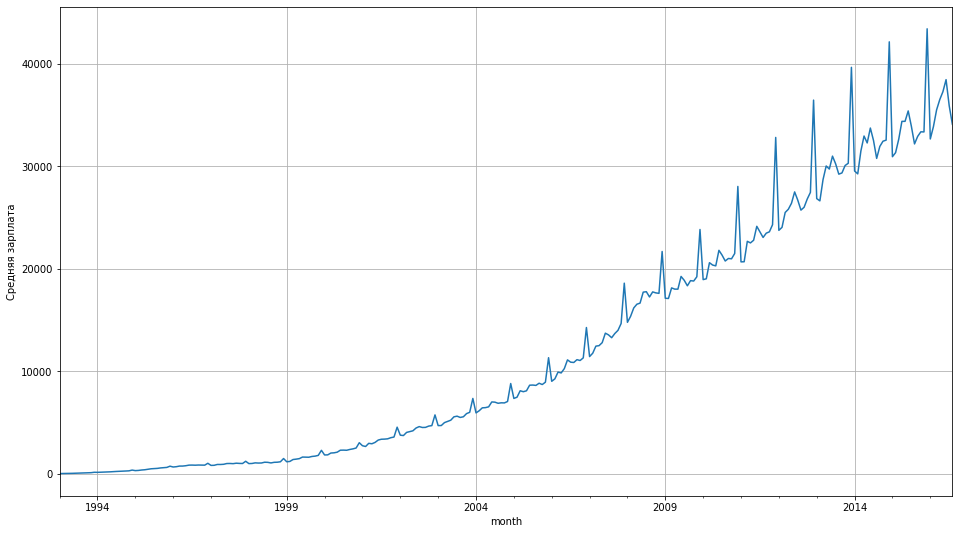

In [23]:
plt.figure(figsize(16, 9))

data.WAG_C_M.plot()

plt.ylabel('Средняя зарплата')
plt.grid()
plt.show()

Критерий Дики-Фуллера: p=0.991850


<Figure size 1152x720 with 0 Axes>

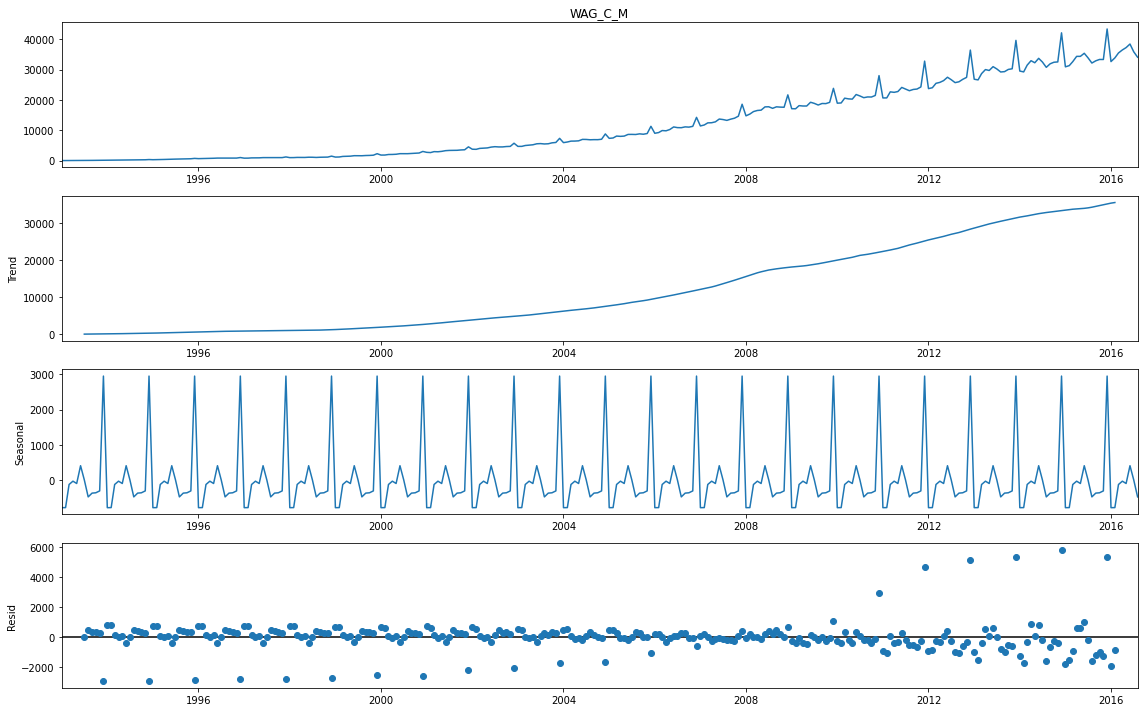

In [19]:
#STL decomposition
plt.figure(figsize(16, 10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

plt.show()

### Вывод
- необходимо стабилизровать дисперсию
- виден возрастающий тренд
- ярко выраженная годовая сезонность

## 1.2. Преборазование Бокса-Кокса

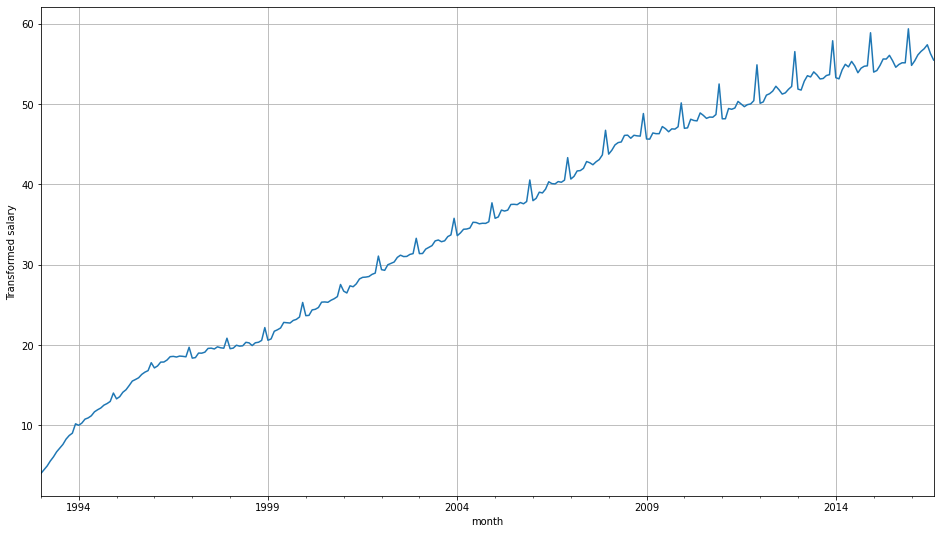

In [25]:
data['salary_box'], l = stats.boxcox(data['WAG_C_M'])

plt.figure(figsize(16,9))

data.salary_box.plot()

plt.ylabel('Transformed salary')
plt.grid()
plt.show()

Критерий Дики-Фуллера: p=0.696899


<Figure size 1152x720 with 0 Axes>

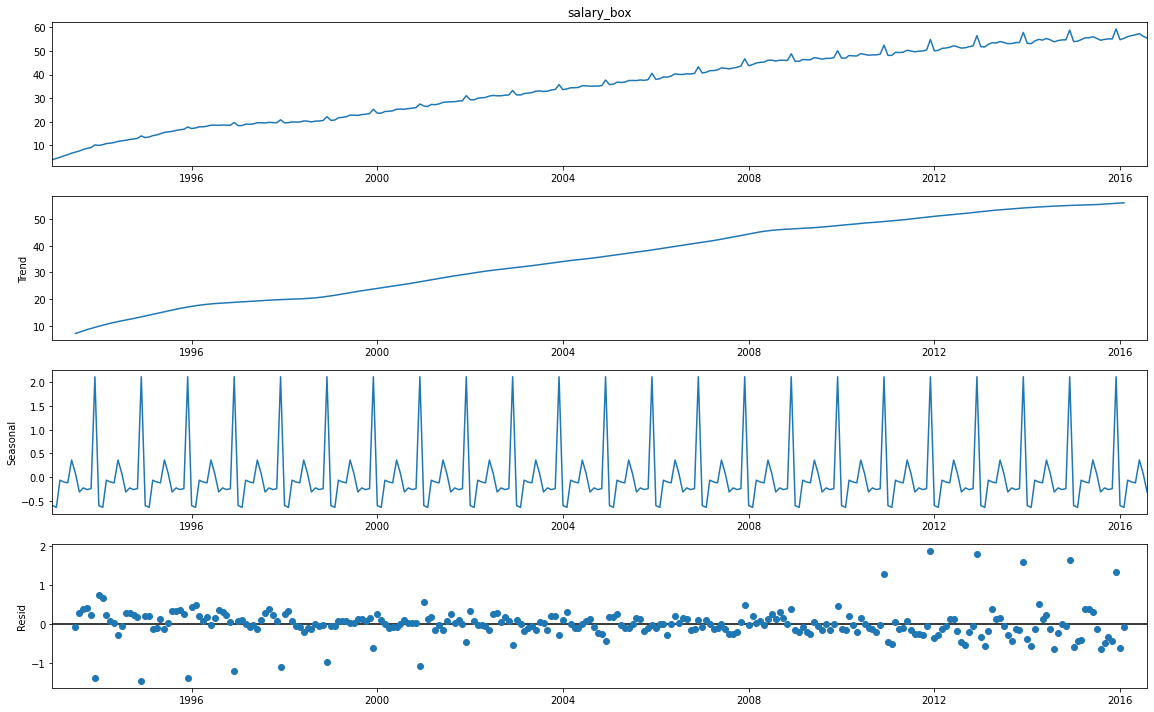

In [26]:
#STL decomposition
plt.figure(figsize(16, 10))
sm.tsa.seasonal_decompose(data.salary_box).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_box)[1])

plt.show()

## 1.3. Дифференцирование ряда

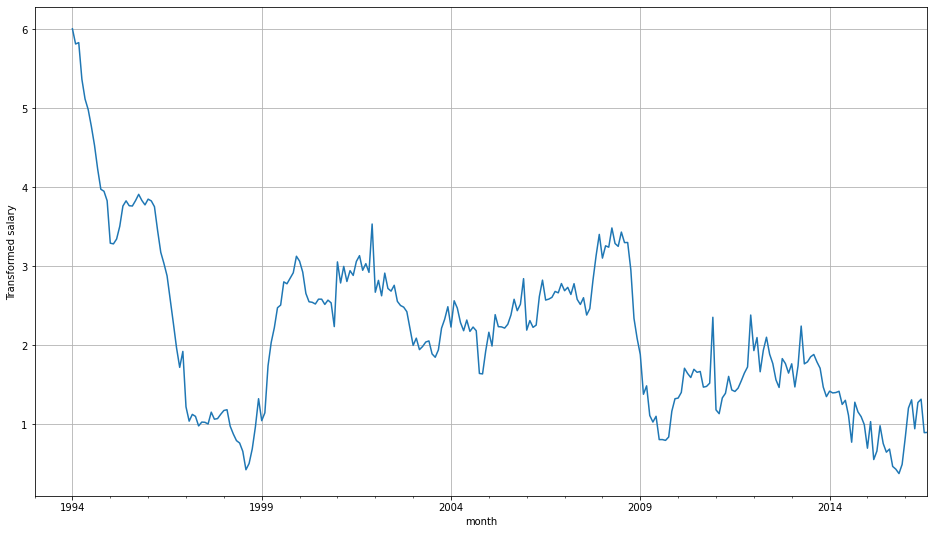

In [27]:
data['salary_diff12'] = data.salary_box - data.salary_box.shift(12)

plt.figure(figsize(16,9))

data.salary_diff12.plot()

plt.ylabel('Transformed salary')
plt.grid()
plt.show()

Критерий Дики-Фуллера: p=0.014697


<Figure size 1152x720 with 0 Axes>

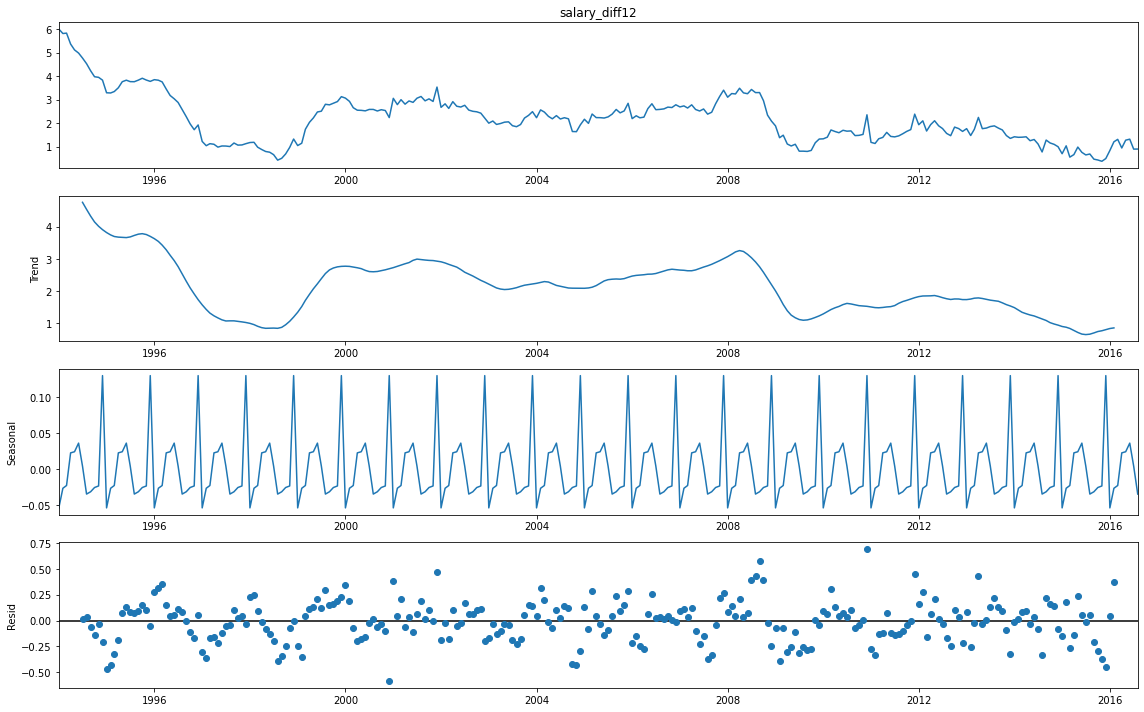

In [31]:
#STL decomposition
plt.figure(figsize(16, 10))
sm.tsa.seasonal_decompose(data.salary_diff12[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_diff12[12:])[1])

plt.show()

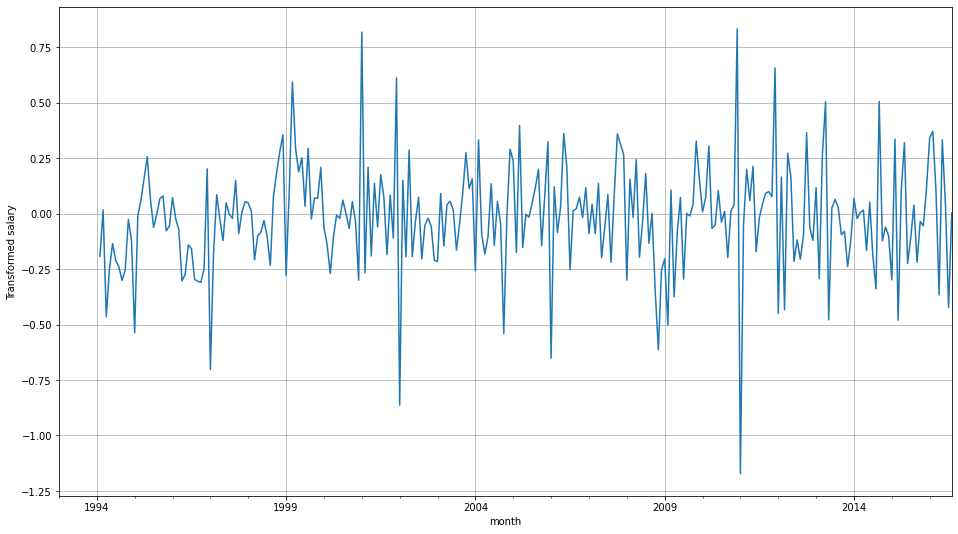

In [32]:
data['salary_diff'] = data.salary_diff12 - data.salary_diff12.shift(1)

plt.figure(figsize(16,9))

data.salary_diff.plot()

plt.ylabel('Transformed salary')
plt.grid()
plt.show()

Критерий Дики-Фуллера: p=0.000000


<Figure size 1152x720 with 0 Axes>

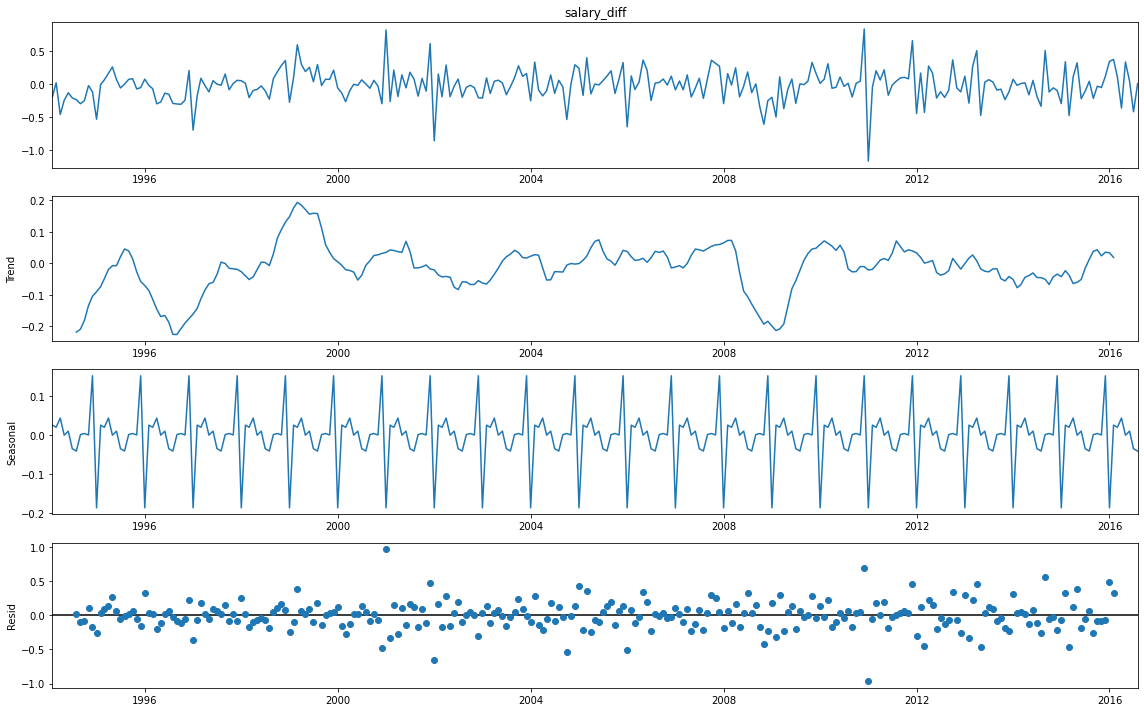

In [34]:
#STL decomposition
plt.figure(figsize(16, 10))
sm.tsa.seasonal_decompose(data.salary_diff[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_diff[13:])[1])

plt.show()

### Вывод
- гипотеза нестационарности отвергается, перейдём к подбору модели

# 2. Подбор модели

## 2.1. Подбор P, p, Q,q

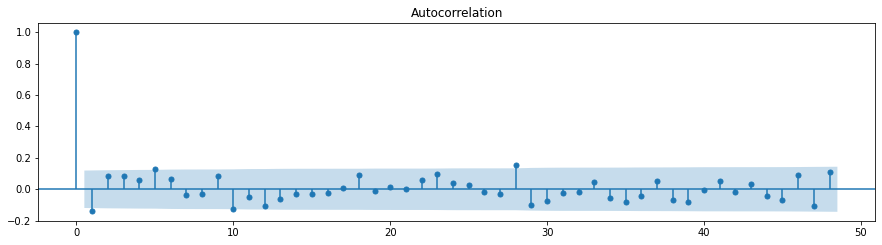

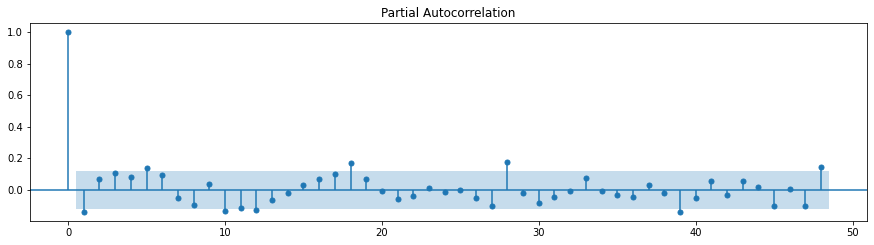

In [37]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.salary_diff[13:].values.squeeze(), lags=48, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.salary_diff[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

Начальные приближения: $Q = 0$, $q = 1$, $p = 11$, $P = 1$

In [38]:
D = 1
d = 1
ps = range(12)
Ps = range(2)
Qs = range(1)
qs = range(2)

In [41]:
from itertools import product

params = product(ps, Ps, Qs, qs)
params_list = list(params)

In [42]:
len(params_list)

48

In [60]:
import warnings

results = []
best_aic = float('inf')
warnings.filterwarnings('ignore')

for param in params_list:
    try:
        model = sm.tsa.statespace.SARIMAX(data.salary_box, order=(param[0], d, param[1]),
                                         seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    
    except:
        continue
    
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [61]:
print(f'Best aic = {best_aic}')

Best aic = -8.755247582542218


In [62]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters       aic
45  (11, 0, 0, 1) -8.755248
47  (11, 1, 0, 1) -7.880281
43  (10, 1, 0, 1) -6.746419
25   (6, 0, 0, 1) -6.591533
42  (10, 1, 0, 0) -5.958380


In [63]:
print(best_model.summary())

                                       SARIMAX Results                                       
Dep. Variable:                            salary_box   No. Observations:                  284
Model:             SARIMAX(11, 1, 0)x(0, 1, [1], 12)   Log Likelihood                  17.378
Date:                               Thu, 27 Aug 2020   AIC                             -8.755
Time:                                       15:08:22   BIC                             38.072
Sample:                                   01-01-1993   HQIC                            10.047
                                        - 08-01-2016                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2080      0.048     -4.301      0.000      -0.303      -0.113
ar.L2      

## 2.2 Анализ остатков

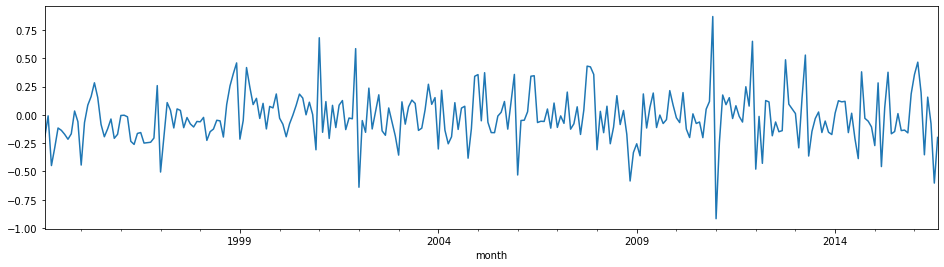

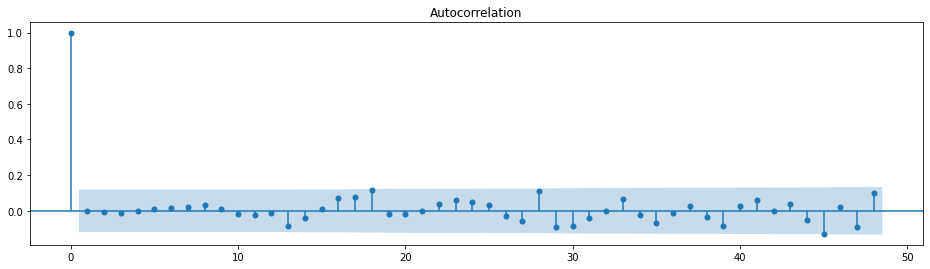

Критерий Стьюдента: p=0.122973
Критерий Дики-Фуллера: p=0.000000


In [64]:
plt.figure(figsize(16,9))
ax = plt.subplot(211)
best_model.resid[13:].plot()
plt.show()

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
plt.show()

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [65]:
def invboxcox(y, lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda * y + 1) / lmbda))

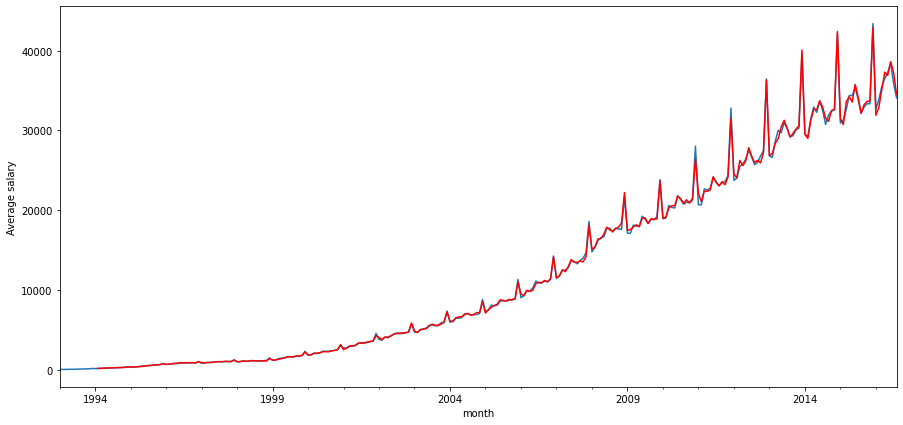

In [66]:
data['model'] = invboxcox(best_model.fittedvalues, l)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('Average salary')
plt.show()

# 3. Прогноз  

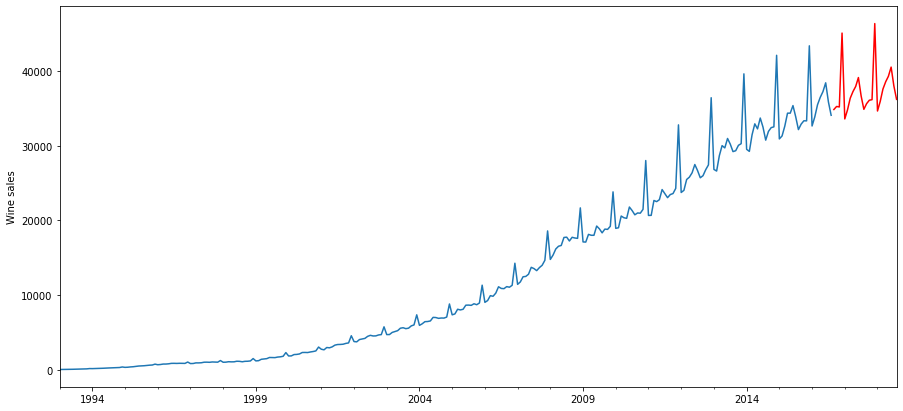

In [78]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) 
             for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=len(data), end=len(data) + 23), l)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()